## Imports

In [1]:
!pip install torch numpy pandas networkx matplotlib pygraphviz

import os
import gc
import re
import sys
import abc
import math
import time
import json
import psutil
import shutil
import inspect
import logging
import argparse
import itertools
import subprocess
# comma-separated and wildcard imports are handled!
from typing import *
from enum import Enum, auto
from datetime import datetime
from copy import copy, deepcopy
from functools import partial, lru_cache
from collections import Counter, defaultdict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from tensorflow.image import random_contrast, random_saturation

import numpy as np
import pandas as pd
import networkx as nx
from matplotlib.path import Path
from matplotlib import pyplot as plt

2024-08-29 15:11:10.883587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utils

---
This is a **Markdown Command** example

_(double-click me to preview the command)_

<!---
Commands have a leading `$` and could be used to amend the generated module tree's structure.
This particular command renames this package from "Utils" to "utilities"

$node=utilities
-->

### File Utils

<!-- no commands here, this should be refactored to `./utilities/file_utils.py` -->

In [2]:
# redundantly importing `os` (on purpose)
import os
# unused import statement (on purpose)
import numpy as np
# we will also randomly use pandas, which was declared in the previous cell

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def the_pandas_func():
    # this is just to showcase our CDA at work
    # this module should contain 2 dependencies given our used definitions here
    # `os` and `pandas as pd`
    
    df = pd.DataFrame()
    del df
    
    

### Image Utils

---
*Uncommented commands also work!*

$module=image_utilities

In [3]:
# dependencies are imported in cell #1, 
# but should be injected during the refactoring process

# This module is borrowed from HiveNAS (https://github.com/ThunderStruct/HiveNAS/blob/main/src/utils/image_aug.py)

class ImageUtils:
    '''Wraps a bunch of static methods for image augmentations
    using Tensorflow/Keras.
    '''

    @staticmethod
    def random_cutout(np_tensor, cutout_color=127):
        '''Randomly applies cutout augmentation to a given rank 3 tensor as
        defined in [1]. Defaults to grey cutout

        [1] DeVries, T., & Taylor, G. W. (2017). Improved regularization of
        convolutional neural networks with cutout.

        Args:
            np_tensor (:class:`numpy.array`): rank 3 numpy tensor-respresentation of \
            the data sample
            cutout_color (int, optional): RGB-uniform value of the cutout color \
            *(defaults to grey (:code:`127`). white (:code:`255`) and black \
            (:code:`0`) are also valid)*

        Returns:
            :class:`numpy.array`: augmented numpy tensor (with a random cutout)
        '''

        cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
        cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])

        cutout_height_point = np.random.randint(np_tensor.shape[0] - cutout_height)
        cutout_width_point = np.random.randint(np_tensor.shape[1] - cutout_width)
        
        ret_tensor = np_tensor.copy()
        ret_tensor[cutout_height_point: cutout_height_point + cutout_height,
                  cutout_width_point: cutout_width_point + cutout_width,
                  :] = cutout_color    # 127 = grey cutout,
                                       # 0 (black) or 255 (white) also valid

        return np.array(ret_tensor)


    @staticmethod
    def random_contrast(np_tensor):
        '''Apply random contrast augmentation

        Args:
            np_tensor (:class:`numpy.array`): rank 3 numpy tensor-respresentation of \
            the data sample

        Returns:
            (:class:`numpy.array`): transformed numpy tensor with random contrast
        '''

        return np.array(random_contrast(np_tensor, 0.25, 3))


    @staticmethod
    def random_saturation(np_tensor):
        '''Apply random saturation augmentation (only works on RGB images, \
        skipped on grayscale datasets)

        Args:
            np_tensor (:class:`numpy.array`): rank 3 numpy tensor-respresentation of \
            the data sample

        Returns:
            (:class:`numpy.array`): transformed numpy tensor with random saturation
        '''

        if np_tensor.shape[-1] != 3:
            # not an RGB image, skip (cannot do saturation aug)
            return np.array(np_tensor)

        return np.array(random_saturation(np_tensor, 0.2, 3))




### Plotting Utils

#### Visualize Minimax

In [4]:

def visualize_minimax_tree(G, root, max_depth=2):
    def get_node_depth(node):   # FYI: local-scope declarations are not tracked through the CDA!
        try:
            return nx.shortest_path_length(G, source=root, target=node)
        except nx.NetworkXNoPath:
            return float('inf')

    def get_move_label(parent_board, child_board):
        for i in range(len(parent_board)):
            if parent_board[i] != child_board[i]:
                row = i // 3
                col = i % 3
                return f'{child_board[i]} to {row},{col}'
        return 'Start'

    # filter nodes that are within max_depth (otherwise it will take forever to plot as the tree is huge)
    nodes_within_depth = [node for node in G.nodes() if get_node_depth(node) <= max_depth]
    filtered_G = G.subgraph(nodes_within_depth)

    # abbreviate states for readability
    labels = {}
    for node in filtered_G.nodes():
        if node == root:
            labels[node] = 'Start'
        else:
            parent = list(filtered_G.predecessors(node))[0]
            labels[node] = get_move_label(parent, node)


    pos = nx.nx_agraph.graphviz_layout(filtered_G, prog='dot')


    plt.figure(figsize=(12, 12))
    nx.draw(filtered_G, pos, labels=labels, with_labels=True, node_size=150, node_color="lightblue", font_size=8, font_color="black")
    plt.show()
    
    


_(double-click me to preview the command)_

<!-- $declare-module=visualize_img_aug -->

In [5]:

def plot_img_aug(sample_image, augmented_image, aug_title):
    # Plot original and augmented images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(aug_title)
    plt.imshow(augmented_image)
    plt.axis('off')

    plt.show()
    
    

## Image Augmentation at Work!


_(double-click me to preview the command)_

<!-- $node=image_augmentation -->

### Img Aug

In [6]:

from tensorflow.keras.datasets import cifar10

class ImageAugmentation:
    def __init__(self):
        # Load sample image from CIFAR-10 dataset
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def get_sample(self, sample_idx=0):
        return self.x_train[sample_idx]

    def get_cutout(self, sample_idx=0):
        return ImageUtils.random_cutout(self.get_sample(sample_idx))

    def get_saturated(self, sample_idx=0):
        return ImageUtils.random_saturation(self.get_sample(sample_idx))
    
    def get_contrasted(self, sample_idx=0):
        return ImageUtils.random_contrast(self.get_sample(sample_idx))
    
        

### Plotting Img Aug

#### Cutout Plot 

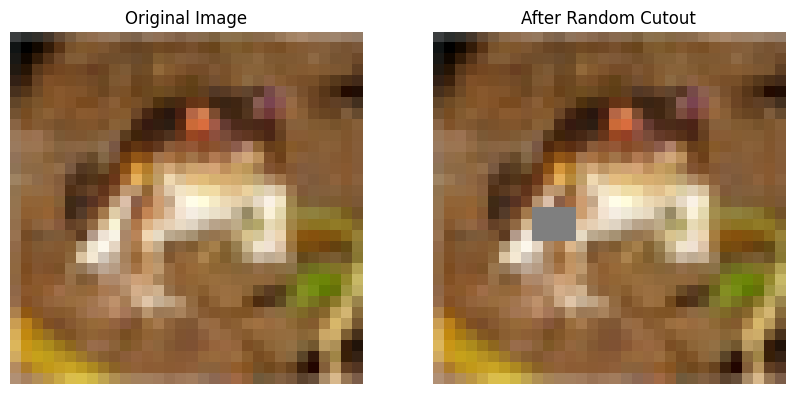

In [7]:
img_aug = ImageAugmentation()

plot_img_aug(img_aug.get_sample(), img_aug.get_cutout(), 'After Random Cutout')



#### Sat. Plot

2024-08-29 15:11:19.762866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


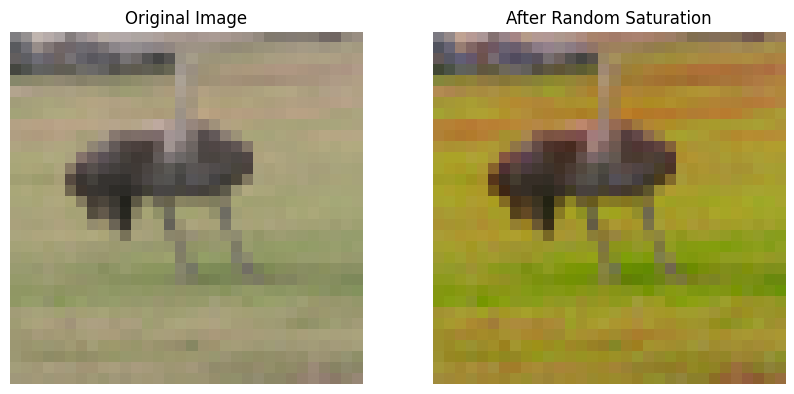

In [8]:
img_aug = ImageAugmentation()

plot_img_aug(img_aug.get_sample(42), img_aug.get_saturated(42), 'After Random Saturation')



#### Contrast Plot

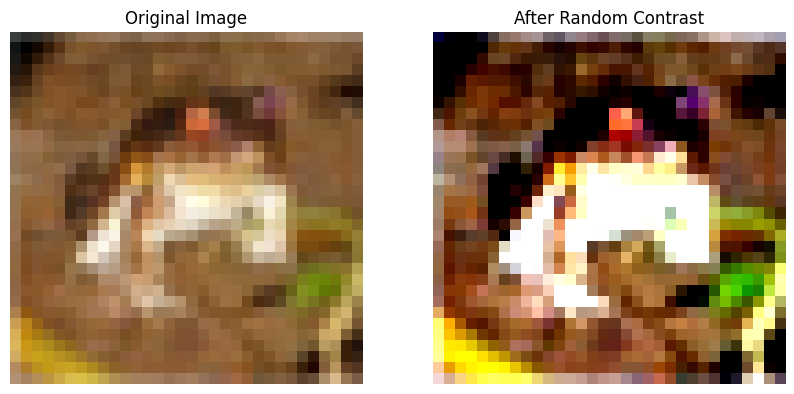

In [9]:
img_aug = ImageAugmentation()

plot_img_aug(img_aug.get_sample(), img_aug.get_contrasted(), 'After Random Contrast')



## Game Time!

_(double-click me to preview the command)_

<!-- $package=game -->

### TicTacToe with Minimax

This package demonstrates a TicTacToe game where the opponent uses the Minimax algorithm to play optimally.

---
This markdown cell is ignored and not factored into the resultant module tree structure.

_(double-click me to preview the command)_

<!-- $ignore-markdown -->

### The Game Board


_(double-click me to preview the command)_

<!-- $module=tic_tac_toe.py -->

In [10]:
class TicTacToe:
    def __init__(self):
        self.board = [' ' for _ in range(9)]
        self.current_winner = None

    def print_board(self):
        for row in [self.board[i * 3:(i + 1) * 3] for i in range(3)]:
            print('| ' + ' | '.join(row) + ' |')

    @staticmethod
    def print_board_nums():
        number_board = [[str(i) for i in range(j * 3, (j + 1) * 3)] for j in range(3)]
        for row in number_board:
            print('| ' + ' | '.join(row) + ' |')

    def available_moves(self):
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def empty_squares(self):
        return ' ' in self.board

    def num_empty_squares(self):
        return self.board.count(' ')

    def make_move(self, square, letter):
        if self.board[square] == ' ':
            self.board[square] = letter
            if self.winner(square, letter):
                self.current_winner = letter
            return True
        return False

    def winner(self, square, letter):
        row_ind = square // 3
        row = self.board[row_ind * 3:(row_ind + 1) * 3]
        if all([spot == letter for spot in row]):
            return True

        col_ind = square % 3
        column = [self.board[col_ind + i * 3] for i in range(3)]
        if all([spot == letter for spot in column]):
            return True

        if square % 2 == 0:
            diagonal1 = [self.board[i] for i in [0, 4, 8]]
            if all([spot == letter for spot in diagonal1]):
                return True
            diagonal2 = [self.board[i] for i in [2, 4, 6]]
            if all([spot == letter for spot in diagonal2]):
                return True
        return False


### Minimax

In [11]:


def minimax(state, depth, maximizing_player, game):
    if game.current_winner == 'O':
        return {'position': None, 'score': 1 * (depth + 1)}  # maximizing
    elif game.current_winner == 'X':
        return {'position': None, 'score': -1 * (depth + 1)}  # minimizing
    elif not game.empty_squares():
        return {'position': None, 'score': 0}

    if maximizing_player:
        best = {'position': None, 'score': -math.inf}
    else:
        best = {'position': None, 'score': math.inf}

    for possible_move in game.available_moves():

        game.make_move(possible_move, 'O' if maximizing_player else 'X')

        sim_score = minimax(state, depth + 1, not maximizing_player, game)

        game.board[possible_move] = ' '
        game.current_winner = None
        sim_score['position'] = possible_move


        if maximizing_player:
            if sim_score['score'] > best['score']:
                best = sim_score
        else:
            if sim_score['score'] < best['score']:
                best = sim_score

    return best


### Visualize Minimax Tree


_(double-click me to preview the command)_

<!-- $node=visualize.py -->

In [12]:

class MinimaxTreeVisualizer:
    def __init__(self):
        self.graph = nx.DiGraph()

    def build_tree(self, game, depth=0, maximizing_player=True):
        self.root = tuple(game.board)
        self._build_tree_recursive(game, depth, maximizing_player, self.root)

    def _build_tree_recursive(self, game, depth, maximizing_player, parent_node):
        if game.current_winner or not game.empty_squares():
            return
        for move in game.available_moves():
            game.make_move(move, 'O' if maximizing_player else 'X')
            child_node = tuple(game.board)
            self.graph.add_edge(parent_node, child_node)
            self._build_tree_recursive(game, depth + 1, not maximizing_player, child_node)
            game.board[move] = ' '
            game.current_winner = None

    def plot_tree(self, max_depth=2):
        visualize_minimax_tree(self.graph, self.root, max_depth)
        
        

In [13]:
# this cell will be appended to the previous module

def init_game(plot=False):
    
    game = TicTacToe()
    
    if plot:
        visualizer = MinimaxTreeVisualizer()
        visualizer.build_tree(game)
        visualizer.plot_tree()
        
    return game
    


### Play

In [14]:
def play_game():
    
    game = init_game(plot=False)
    
    game.print_board_nums()

    while game.empty_squares():
        if game.num_empty_squares() % 2 == 0:
            square = minimax(None, 0, True, game)['position']
        else:
            valid_square = False
            while not valid_square:
                square = input('Choose a move (0-8): ')
                try:
                    square = int(square)
                    if square not in game.available_moves():
                        raise ValueError
                    valid_square = True
                except ValueError:
                    print("Invalid square. Try again.")

        if game.make_move(square, 'O' if game.num_empty_squares() % 2 == 0 else 'X'):
            game.print_board()
            print('')

            if game.current_winner:
                print(f'{game.current_winner} wins!')
                return
    print("It's a tie!")


play_game()


| 0 | 1 | 2 |
| 3 | 4 | 5 |
| 6 | 7 | 8 |


KeyboardInterrupt: Interrupted by user